# Disaster Challenge Part 2  
EM-DAT 災害データ分析（Functions & Loops & Map）

このノートブックでは、EM-DAT の災害データを使って以下を行い、災害の特徴を視覚的に分析する。  
- **関数（Function）**  
- **ループ（Loop）**  
- **マップ可視化（Bonus）**  


分析のフォーカスは以下の3つ：
1. 国別の災害タイプの違い  
2. 珍しい災害タイプ（発生件数の少ない災害）の発見  
3. 地図上での災害発生国の分布  


In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import folium

# 日本語フォント対策
plt.rcParams['font.family'] = 'MS Gothic'

# データ読み込み
df = pd.read_csv('emdat.csv')
df.head()


,Disaster Subgroup,Disaster Type,Disaster Subtype,ISO,Country,Subregion,Region,Latitude,Longitude,Start Year,Total Deaths
0,Meteorological,Storm,Tropical cyclone,USA,United States of America,Northern America,Americas,NaN,NaN,1900,6000.0
1,Hydrological,Flood,Flood (General),JAM,Jamaica,Latin America and the Caribbean,Americas,NaN,NaN,1900,300.0
2,Biological,Epidemic,Viral disease,JAM,Jamaica,Latin America and the Caribbean,Americas,NaN,NaN,1900,30.0
3,Geophysical,Volcanic activity,Ash fall,JPN,Japan,Eastern Asia,Asia,NaN,NaN,1900,30.0
4,Geophysical,Earthquake,Ground movement,TUR,Türkiye,Western Asia,Asia,40.3,43.1,1900,140.0


## 関数の目的
今回は「国コード（ISO）」を入れると  
その国で **どの災害タイプがどれだけ発生したか** を自動で可視化する関数を作る。

さらに、珍しい災害タイプを見つける関数、  
指定した国を地図にプロットする関数も作成する。


In [19]:
def plot_disaster_types(country):
    """
    指定した国で発生した災害タイプの件数を棒グラフで表示する関数
    """
    data = df[df['ISO'] == country]

    if data.empty:
        print(f"{country} のデータはありません。")
        return
    
    counts = data['Disaster Type'].value_counts()

    plt.figure(figsize=(10,5))
    counts.plot(kind='bar')
    plt.title(f"{country} の災害タイプ別件数")
    plt.xlabel("災害タイプ")
    plt.ylabel("件数")
    plt.show()


## 関数のサンプル出力（日本の災害タイプ）


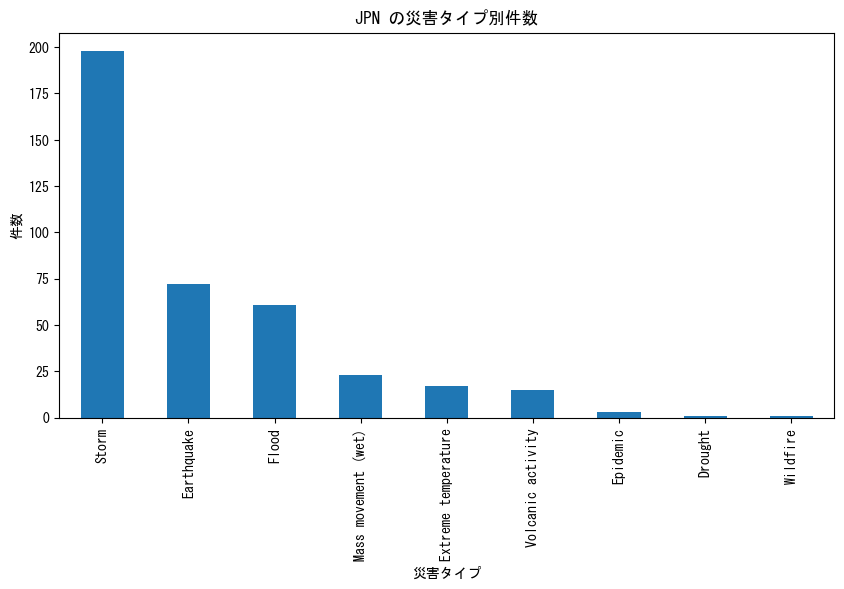

In [20]:
plot_disaster_types('JPN')  # 日本（Japan）


## Loop（for 文）で複数国の災害タイプを連続表示
アジアの災害が多い国をまとめて可視化する。


--- JPN ---


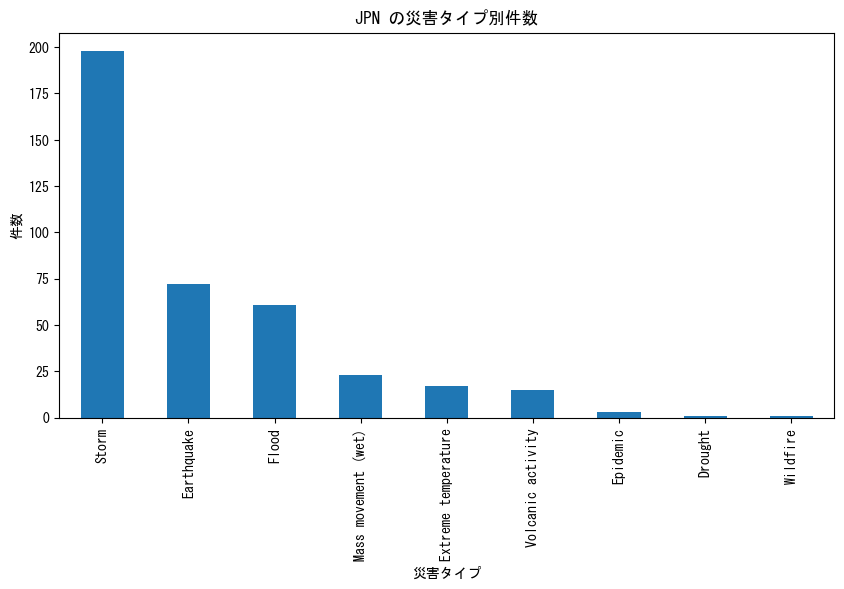

--- CHN ---


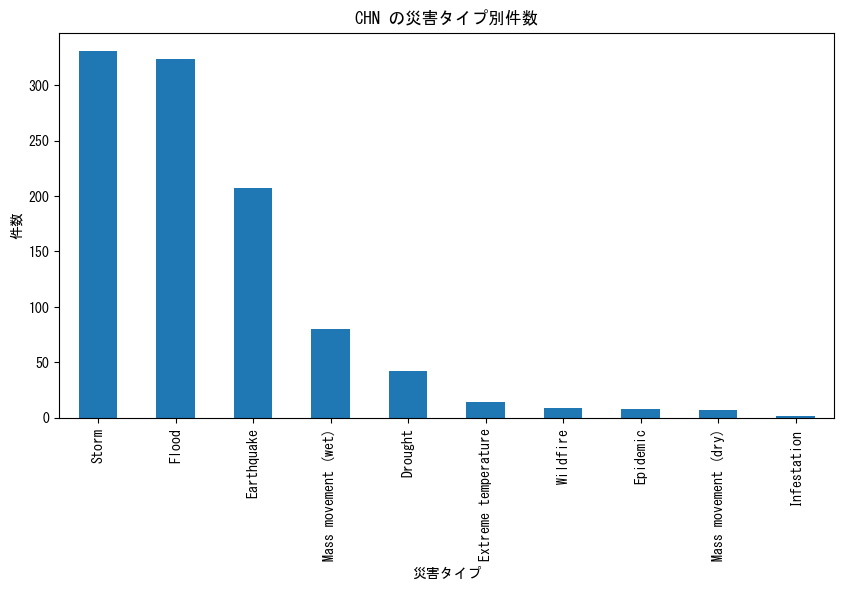

--- PHL ---


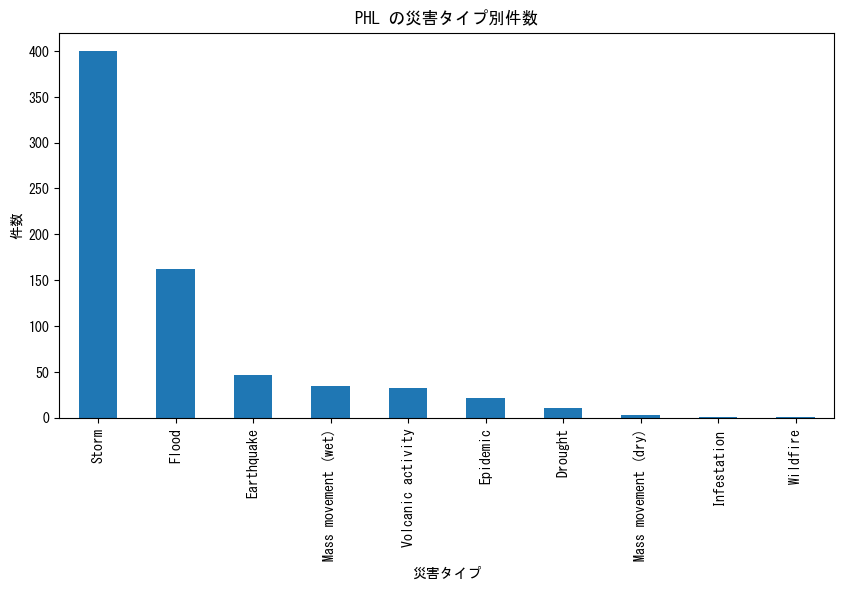

--- IDN ---


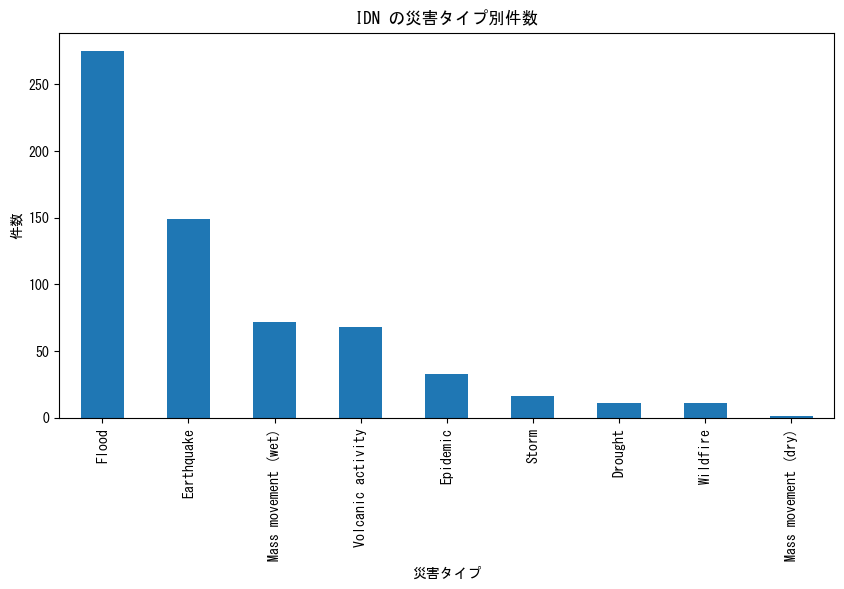

--- IND ---


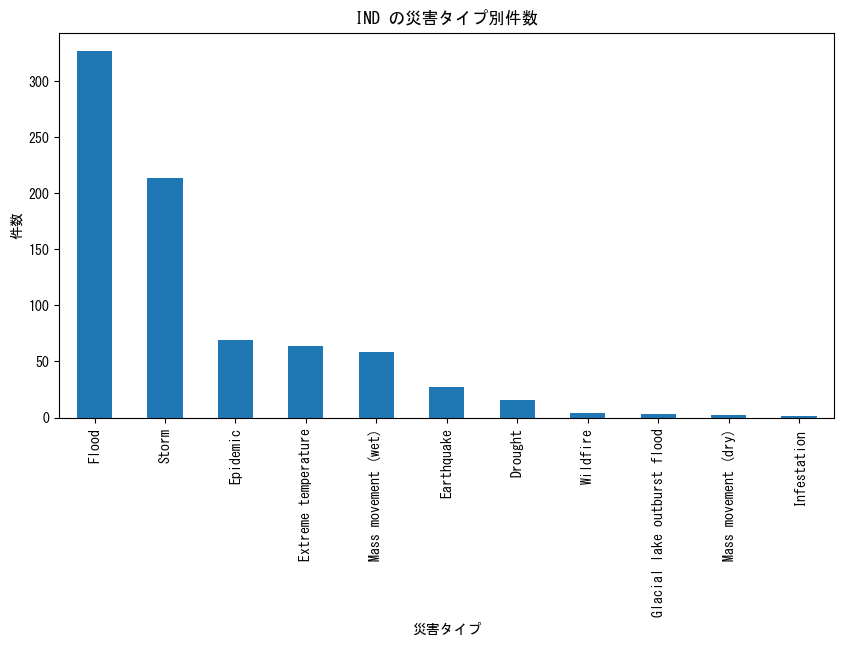

In [21]:
countries = ['JPN', 'CHN', 'PHL', 'IDN', 'IND']  # 日本・中国・フィリピン・インドネシア・インド

for c in countries:
    print(f"--- {c} ---")
    plot_disaster_types(c)


## 珍しい災害タイプの発見
データから「発生件数が少ない珍しい災害」を自動で探す関数を作成する。  
こうした災害はニュースに出ないが、実際には記録されている。


In [27]:
def find_rare_disasters(n=5):
    """
    発生件数の少ない珍しい災害タイプを n 件だけ表示する関数
    """
    counts = df['Disaster Type'].value_counts().tail(n)
    return counts

find_rare_disasters(5)


Disaster Type
Mass movement (dry)            46
Glacial lake outburst flood     5
Fog                             1
Impact                          1
Animal incident                 1
Name: count, dtype: int64

Mass movement (dry)（土砂移動・乾燥系災害）  
　雨による泥流（wet）じゃなくて、火山活動や地震、斜面崩壊などで土砂が勢いよく動くもの  
  
Glacial lake outburst flood（氷河湖決壊洪水）  
　氷河が溶けてできた湖が決壊して大洪水になるもの  
  
Fog（霧災害）  
　濃霧によって大量事故が発生  

Impact（衝撃災害 / 隕石落下など）  
　隕石・スペースデブリ落下・爆発的衝突  

Animal incident（動物災害）  
　動物による死亡事故・大規模被害事件  
　野生動物の大量襲撃や毒性動物の大量発生など？

In [28]:
import folium
from folium import Map, Marker, Icon

# 珍しい災害タイプ
rare_types = [
    "Mass movement (dry)",
    "Glacial lake outburst flood",
    "Fog",
    "Impact",
    "Animal incident"
]

# 珍しい災害抽出＋緯度経度がある行だけ
rare_df = df[df["Disaster Type"].isin(rare_types)].dropna(subset=["Latitude", "Longitude"]).copy()

print("データ件数:", rare_df.shape[0])  # ← ここ大事！0なら地図出るわけがない

# マップ作成（絶対に見れるやつ）
m = folium.Map(location=[20, 0], zoom_start=2, tiles="OpenStreetMap")

# マーカー不具合対策：CircleMarkerも併用
for _, row in rare_df.iterrows():
    lat = float(row["Latitude"])
    lon = float(row["Longitude"])

    folium.CircleMarker(
        location=[lat, lon],
        radius=8,
        color="red",
        fill=True,
        fill_color="red",
        fill_opacity=0.7,
        popup=f"{row['Disaster Type']} ({int(row['Start Year'])})"
    ).add_to(m)

m


データ件数: 0


## 災害発生国の分布を地図上に表示
各国の中心にマーカーを置き、どの国でどのくらい災害が起きているかをマップ化する。


In [24]:
# 国ごとの災害件数
country_counts = df['ISO'].value_counts()

# 世界地図
m = folium.Map(location=[20, 0], zoom_start=2)

# ISO → 緯度経度の簡易辞書（最低限の国だけ）
coords = {
    'JPN': [36, 138],
    'CHN': [35, 105],
    'PHL': [13, 122],
    'IDN': [-5, 120],
    'IND': [20, 78]
}

for iso, count in country_counts.items():
    if iso in coords:
        lat, lon = coords[iso]
        folium.CircleMarker(
            location=[lat, lon],
            radius=5 + count/20,  # 件数で円の大きさ変える
            color='red',
            fill=True,
            tooltip=f"{iso}: {count} 件"
        ).add_to(m)

m


# まとめ

今回の分析では、Function と Loop を使うことで  
災害データの可視化を自動化し、複数国の違いを効率的に比較できた。

### 得られた洞察
- 地域によって発生しやすい災害タイプが大きく異なる  
- 発生件数が極端に少ない珍しい災害も存在する  
- 地図（Map）を使うことで災害の発生国を直感的に把握できた  
- Loop を使うことで、複数地域の比較が一度に可能になり、分析の効率が大きく向上

Function と Loop を組み合わせることで「再利用できる自動分析ツール」として使える構造になった。
